In [1]:
# Install all necessary dependencies evaluation libraries
!pip install -U -q transformers datasets hf_xet sacrebleu evaluate bert-score comet-ml matplotlib tqdm

# BLEURT: clone and install from source (preferred method)
!git clone https://github.com/google-research/bleurt.git
%cd bleurt
!pip install .
%cd ..

!pip install git+https://github.com/Unbabel/COMET

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 

In [2]:
# Project Imports
import os
import json
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
from evaluate import load as load_metric
from bert_score import score as bert_score

In [3]:
# Using datasets library to load 'dev' English source from Hugging Face
from datasets import load_dataset

# Loading the FLORES-200 'dev' split, focusing on English (eng_Latn-nso_Latn)
# This configuration ensures parallel sentences across English and Sepedi languages.
# We're loading the English text we will use to input into our model as the source,
# and the Sepedi (nso_Latn) first reference
print("Loading FLORES-200 English 'dev' split...")
flores_dev = load_dataset("facebook/flores", "eng_Latn-nso_Latn", split="dev", trust_remote_code=True)
print(f"Loaded {len(flores_dev)} English sentences from FLORES-200 'dev' split.")

# Extracting just the English sentences for translation
# We'll use this list as input to our MT models
english_source_sentences_dev = [item['sentence_eng_Latn'] for item in flores_dev]

print("\nFirst 5 English source sentences (DEV):")
for i, sentence in enumerate(english_source_sentences_dev[:5]):
    print(f"{i+1}. {sentence}")

original_sepedi_references_dev = [item['sentence_nso_Latn'] for item in flores_dev]
print(f"Loaded {len(original_sepedi_references_dev)} original Sepedi sentences for 'dev' split.")

print("\nFirst 5 Original Sepedi references (DEV):")
for i, sentence in enumerate(original_sepedi_references_dev[:5]):
    print(f"{i+1}. {sentence}")

# This will be for the final 'devtest' split for comprehensive evaluation later.
# Continuing tests with focus on 'dev' for now.
print("\nLoading FLORES-200 English 'devtest' split...")
flores_devtest = load_dataset("facebook/flores", "eng_Latn-nso_Latn", split="devtest", trust_remote_code=True)
print(f"Loaded {len(flores_devtest)} English sentences from FLORES-200 'devtest' split.")
english_source_sentences_devtest = [item['sentence_eng_Latn'] for item in flores_devtest]

print("\nFirst 5 English source sentences (DEVTEST):")
for i, sentence in enumerate(english_source_sentences_devtest[:5]):
    print(f"{i+1}. {sentence}")

original_sepedi_references_devtest = [item['sentence_nso_Latn'] for item in flores_devtest]
print(f"Loaded {len(original_sepedi_references_devtest)} original Sepedi sentences for 'devtest' split.")

print("\nFirst 5 Original Sepedi references (DEVTEST):")
for i, sentence in enumerate(original_sepedi_references_devtest[:5]):
   print(f"{i+1}. {sentence}")

Loading FLORES-200 English 'dev' split...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

flores.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

Loaded 997 English sentences from FLORES-200 'dev' split.

First 5 English source sentences (DEV):
1. On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
2. Lead researchers say this may bring early detection of cancer, tuberculosis, HIV and malaria to patients in low-income countries, where the survival rates for illnesses such as breast cancer can be half those of richer countries.
3. The JAS 39C Gripen crashed onto a runway at around 9:30 am local time (0230 UTC) and exploded, closing the airport to commercial flights.
4. The pilot was identified as Squadron Leader Dilokrit Pattavee.
5. Local media reports an airport fire vehicle rolled over while responding.
Loaded 997 original Sepedi sentences for 'dev' split.

First 5 Original Sepedi references (DEV):
1. Ka Mošupulogo, b

### Load corrected datasets from dfsi Github repo

In [4]:
# Clone repo
github_repo_url = "https://github.com/dsfsi/flores-fix-4-africa.git"
repo_name = github_repo_url.split('/')[-1].replace('.git', '') # Extracts 'flores-fix-4-africa'
print(f"Cloning GitHub repository: {github_repo_url}")
# Check if the directory already exists to avoid cloning multiple times on reruns
if not os.path.exists(f"/content/{repo_name}"):
    !git clone {github_repo_url}
    print(f"Repository '{repo_name}' cloned successfully.")
else:
    print(f"Repository '{repo_name}' already cloned.")

# Base path to the corrected data within the cloned repository
# The structure is: repo_name/data/corrected/{split_type}/{lang_code}.{split_type}
base_corrected_data_path = os.path.join("/content", repo_name, "data", "corrected")
print(f"Corrected data base path set to: {base_corrected_data_path}")


Cloning GitHub repository: https://github.com/dsfsi/flores-fix-4-africa.git
Cloning into 'flores-fix-4-africa'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 90 (delta 34), reused 75 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 590.03 KiB | 2.06 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Repository 'flores-fix-4-africa' cloned successfully.
Corrected data base path set to: /content/flores-fix-4-africa/data/corrected


In [5]:
def load_corrected_language_data(lang_code: str, split_type: str) -> list:
    """
    Loads corrected reference sentences for a given language and split type
    from the cloned flores-fix-4-africa GitHub repository.

    Args:
        lang_code (str): The language code (e.g., "nso_Latn", "hau_Latn").
        split_type (str): The split type ("dev" or "devtest").

    Returns:
        list: A list of corrected sentences. Returns an empty list if the file is not found.
    """
    # Construct the full file path dynamically
    file_path = os.path.join(base_corrected_data_path, split_type, f"{lang_code}.{split_type}")

    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            sentences = [line.strip() for line in f if line.strip()]
        print(f"Loaded {len(sentences)} corrected '{lang_code}' sentences for '{split_type}'.")
        return sentences
    else:
        print(f"WARNING: Corrected '{lang_code}' '{split_type}' file not found at {file_path}. Skipping.")
        return []

In [6]:
# Loading the corrected data fro the languages
all_corrected_references_by_lang = {
    "dev": {},
    "devtest": {}
}

# All all African languages with corrected data
african_languages_corrected = ["nso_Latn"] #  ["hau_Latn", "nso_Latn", "tso_Latn", "zul_Latn"]

for lang_code in african_languages_corrected:
    all_corrected_references_by_lang["dev"][lang_code] = load_corrected_language_data(lang_code, "dev")
    all_corrected_references_by_lang["devtest"][lang_code] = load_corrected_language_data(lang_code, "devtest")

# Example of accessing the data:
print("\nExample of accessing Sepedi (nso_Latn) dev corrected sentences:")
print(all_corrected_references_by_lang["dev"]["nso_Latn"][:5])

Loaded 997 corrected 'nso_Latn' sentences for 'dev'.
Loaded 1012 corrected 'nso_Latn' sentences for 'devtest'.

Example of accessing Sepedi (nso_Latn) dev corrected sentences:
['Ka Mošupulogo, boramahlale ba go tšwa Sekolong sa Yunibesithi ya Stanford sa tša maphelo ba tsebišitše ka go hlangwa ga sedirišwa se sefsa sa tekolo seo se ka beakanyago disele ka mehuta: chip yeo e gatišegago ye nnyane yeo e ka tšweletšwago ka go šomiša metšhene ya go gatiša ya inkjet ya sente ye tee ya U.S. ka o tee.', 'Banyakišiši ba ketapele ba re se se ka tliša temogo ya kankere, tuberculosis, HIV le malaria go balwetši kapela dinageng tša letseno la fase, moo ditekano tša go phela tša malwetši a bjalo ka kankere ya letswele di ka bago seripa sa tša dinaga tšeo di humilego.', 'JAS 39C Gripen e wetše godimo ga moo sefofane se sepelago gona ka bo 9:30 am nako ya selegae (0230UTC) gomme ya thuthupa, gwa tswalelwa boemafofane bakeng sa difofane tša tefelo.', 'Mootledi wa sefofane o tsebišitšwe bjalo ka Moetape

## Load NLLB-200 Model

In [7]:
# Defining the NLLB-200 model name, and methods to translate and save translations

# nllb_model_name = "facebook/nllb-200-distilled-600M" # lightweight version distilled-600M
nllb_model_name = "facebook/nllb-200-1.3B" # Larger model, may have better quality of results


def save_translations_to_file(
    translated_texts: list,
    output_folder: str,
    filename_prefix: str,
    src_lang: str,
    tgt_lang: str,
    split_type: str
):
    """
    Saves a list of translated texts to a text file.

    Args:
        translated_texts (list): List of strings, where each string is a translated sentence.
        output_folder (str): The directory where the output file will be saved.
        filename_prefix (str): Prefix for the filename (e.g., "nllb200").
        src_lang (str): Source language code.
        tgt_lang (str): Target language code.
        split_type (str): Type of split (e.g., "dev", "devtest").
    """
    output_dir = output_folder
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nSaving model outputs to {output_dir}")

    # Construct the filename dynamically
    output_filename = f"{filename_prefix}_{src_lang}_to_{tgt_lang}_{split_type}.txt"
    full_output_path = os.path.join(output_dir, output_filename)

    try:
        with open(full_output_path, "w", encoding="utf-8") as f:
            for sentence in translated_texts:
                f.write(sentence + "\n")
        print(f"Saved translations to: {full_output_path}")
    except Exception as e:
        print(f"Error saving translations to {full_output_path}: {e}")


def run_nllb_translation_and_save(
    target_lang_code: str,
    split_type: str,
    english_source_sentences: list,
    model_name: str = nllb_model_name,
    output_folder: str = "nllb_generated_translations",
    source_lang_code: str = "eng_Latn",
    device: int = 0 if torch.cuda.is_available() else -1 # 0 for GPU, -1 for CPU
) -> list:
    """
    Loads NLLB-200 model, performs translation for a given target language and split,
    and saves the generated translations to a file.

    Args:
        target_lang_code (str): The FLORES language code for the target language (e.g., "nso_Latn").
        split_type (str): The split type ("dev" or "devtest").
        english_source_sentences (list): List of English sentences to translate for this split.
        model_name (str): Name of the NLLB model to use.
        output_folder (str): Directory to save the output files.
        source_lang_code (str): Source language code, defaults to "eng_Latn".

    Returns:
        list: A list of the generated translated texts. Returns an empty list on error.
    """

    selected_device_info = "GPU" if device == 0 else "CPU"
    print(f"\n--- Running NLLB-200 Translation for {source_lang_code} to {target_lang_code} ({split_type.upper()} set) ---")
    print(f"Using device: {selected_device_info}")

    try:
        # Initialize the pipeline for the specific language pair
        nllb_translator = pipeline(
            'translation',
            model=model_name,
            src_lang=source_lang_code,
            tgt_lang=target_lang_code,
            device=device # Use GPU if available (0 is usually the first GPU)
        )
        print(f"NLLB-200 model '{model_name}' loaded successfully for {source_lang_code} to {target_lang_code}.")

        print(f"Generating translations for {target_lang_code} ({split_type} set)... This might take a few minutes for 1000 sentences.")
        nllb_translations_raw = nllb_translator(english_source_sentences)
        nllb_translated_texts = [item['translation_text'] for item in nllb_translations_raw]
        print(f"Generated {len(nllb_translated_texts)} translations for {target_lang_code} ({split_type} set).")

        print(f"\nFirst 5 NLLB-200 generated translations for {target_lang_code} ({split_type.upper()} set):")
        for i, translation in enumerate(nllb_translated_texts[:5]):
          print(f"{i+1}. {translation}")

        # Save the generated translations
        save_translations_to_file(
            translated_texts=nllb_translated_texts,
            output_folder=output_folder,
            filename_prefix="nllb200",
            src_lang=source_lang_code,
            tgt_lang=target_lang_code,
            split_type=split_type
        )

        return nllb_translated_texts

    except Exception as e:
        print(f"An error occurred during NLLB-200 translation or saving for {target_lang_code} ({split_type} set): {e}")
        return []

## Translating + Saving model translation outputs for Evaluation

In [8]:
# # Save time load the MT outputs from our github repo, comment in from below until "# Run MT" for loading
# # translations from our Github or leave as is for real time MT outputs generations:

# # Load translations from File / Model outputs

# # GitHub repo details
# lost_in_translations_github_repo_url = "https://github.com/lerato1ofwan/760-lost-in-translation.git"
# lost_in_translations_repo_name = lost_in_translations_github_repo_url.split('/')[-1].replace('.git', '')  # "760-lost-in-translation"
# repo_path = f"/content/{lost_in_translations_repo_name}"

# # Clone the repo (if not already cloned)
# print(f"Cloning GitHub repository: {lost_in_translations_github_repo_url}")
# if not os.path.exists(repo_path):
#     !git clone {lost_in_translations_github_repo_url} {repo_path}
#     print(f"Repository '{lost_in_translations_repo_name}' cloned successfully.")
# else:
#     print(f"Repository '{lost_in_translations_repo_name}' already cloned.")

# # File loading helper
# def load_file(file_path):
#     with open(file_path, 'r', encoding='utf-8') as f:
#         return [line.strip() for line in f if line.strip()]

# # Construct full path to mt_outputs directory
# mt_outputs_path = os.path.join(repo_path, "data", "mt_outputs")
# print(f"MT Outputs data base path set to: {mt_outputs_path}")

# # Load model output files
# dev_translations = load_file(os.path.join(mt_outputs_path, "3B_nllb200_eng_Latn_to_nso_Latn_dev.txt"))
# devtest_translations = load_file(os.path.join(mt_outputs_path, "3B_nllb200_eng_Latn_to_nso_Latn_devtest.txt"))

# # Print loaded sizes
# print(f"Loaded {len(dev_translations)} dev translations")
# print(f"Loaded {len(devtest_translations)} devtest translations")


# Run MT

 # --- Translations and Saving the outputs for later Evaluations: ---
# We first define the target languages we will use, the dev and devtest translations
# For each target language we invoke the function -> "run_nllb_translation_and_save" for dev and devtest

african_target_languages = ["nso_Latn"] # ["hau_Latn", "nso_Latn", "tso_Latn", "zul_Latn"] # All 4 languages

# You might want to store all results in a dictionary for easy access
all_nllb_translations = {
    "dev": {},
    "devtest": {}
}

for target_lang in african_target_languages:
    print(f"\n--- Processing {target_lang} ---")

    # For FLORES, the English source sentences usually remain the same across different target evaluations.
    # So, english_source_sentences_dev and english_source_sentences_devtest can be reused.

    dev_translations = run_nllb_translation_and_save(
        target_lang_code=target_lang,
        split_type="dev",
        english_source_sentences=english_source_sentences_dev, # Use the global DEV English sentences
        output_folder="nllb_generated_translations_distilled"
    )
    all_nllb_translations["dev"][target_lang] = dev_translations

    devtest_translations = run_nllb_translation_and_save(
        target_lang_code=target_lang,
        split_type="devtest",
        english_source_sentences=english_source_sentences_devtest,  # Use the global DEVTEST English sentences
        output_folder="nllb_generated_translations_distilled"
    )
    all_nllb_translations["devtest"][target_lang] = devtest_translations

print("\n--- All NLLB-200 translations generated and saved for all specified languages. ---")

# Final summarative prints
print("\n--- Verification of a sample generated translation (DEV Sepedi) ---")
if "nso_Latn" in all_nllb_translations["dev"]:
    print("First 5 generated Sepedi (nso_Latn) sentences (DEV):")
    for i, sentence in enumerate(all_nllb_translations["dev"]["nso_Latn"][:5]):
        print(f"{i+1}. {sentence}")
else:
    print("Sepedi (nso_Latn) DEV translations not found in all_nllb_translations dictionary.")


--- Processing nso_Latn ---

--- Running NLLB-200 Translation for eng_Latn to nso_Latn (DEV set) ---
Using device: GPU


config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

Device set to use cuda:0


NLLB-200 model 'facebook/nllb-200-1.3B' loaded successfully for eng_Latn to nso_Latn.
Generating translations for nso_Latn (dev set)... This might take a few minutes for 1000 sentences.
Generated 997 translations for nso_Latn (dev set).

First 5 NLLB-200 generated translations for nso_Latn (DEV set):
1. Ka Mošupologo, bo-rathutamahlale ba Sekolo sa tša Kalafo sa Yunibesithi ya Stanford ba ile ba tsebiša ka go hlangwa ga sedirišwa se sefsa sa go hlahloba seo se kgonago go arola disele go ya ka mohuta wa tšona: chip e nyenyane yeo e ka gatišwago yeo e ka tšweletšwago ka go diriša metšhene e tlwaelegilego ya go gatiša ka go diriša enke yeo e sa bitšego tšhelete e ka bago sente e tee ya U.S. e nngwe le e nngwe.
2. Banyakišiši ba bagolo ba bolela gore se se ka dira gore balwetši ba dinageng tšeo di humilego ba kgone go lemoga kankere, bolwetši bja mafahla, HIV le malaria e sa le ka pela, moo tekanyo ya go phologa ga malwetši a bjalo ka kankere ya matswele e ka bago seripa-gare sa ya dinaga 

Device set to use cuda:0


NLLB-200 model 'facebook/nllb-200-1.3B' loaded successfully for eng_Latn to nso_Latn.
Generating translations for nso_Latn (devtest set)... This might take a few minutes for 1000 sentences.
Generated 1012 translations for nso_Latn (devtest set).

First 5 NLLB-200 generated translations for nso_Latn (DEVTEST set):
1. O okeditše ka gore: "Ga bjale re na le magotlo a dikgwedi tše 4 ao e sego a bolwetši bja swikiri ao a kilego a ba le bolwetši bja swikiri".
2. Dr. Ehud Ur, moprofesara wa tša kalafo Yunibesithing ya Dalhousie kua Halifax, Nova Scotia le modula-setulo wa lefapha la tša kalafo le tša thutamahlale la Canadian Diabetes Association o lemošitše gore nyakišišo e sa le matšatšing a yona a mathomo.
3. Go swana le ditsebi tše dingwe, o belaela ge e ba bolwetši bja swikiri bo ka alafega, a bolela gore dilo tše di hweditšwego ga di na mohola go batho bao ba šetšego ba e-na le bolwetši bja swikiri bja Mohuta wa 1.
4. Ka Mošupologo, Sara Danius, e lego mongwaledi wa ka mehla wa Komiti ya

## Evaluations

In [9]:
from sacrebleu.metrics import CHRF, BLEU
from bert_score import score


In [11]:
bleu_metric = BLEU()
chrf_metric = CHRF()

def evaluate_set(name, model_outputs, source_sentences, original_refs, corrected_refs, device):
    print(f"📘 Evaluating: {name}")
    bleu = BLEU()
    chrf = CHRF()

    # Format for multi-reference
    multi_refs = [[o, c] for o, c in zip(original_refs, corrected_refs)]

    # Metrics
    bleu_orig = bleu.corpus_score(model_outputs, [[o] for o in original_refs])
    bleu_corr = bleu.corpus_score(model_outputs, [[c] for c in corrected_refs])
    bleu_multi = bleu.corpus_score(model_outputs, multi_refs)

    chrf_orig = chrf.corpus_score(model_outputs, [[o] for o in original_refs])
    chrf_corr = chrf.corpus_score(model_outputs, [[c] for c in corrected_refs])
    chrf_multi = chrf.corpus_score(model_outputs, multi_refs)

    # BERTScore (corrected only) - NOW WITH DEVICE SPECIFIED
    _, _, F_corr = score(model_outputs, corrected_refs, lang='nso', rescale_with_baseline=True, device=device)
    _, _, F_orig = score(model_outputs, original_refs, lang='nso', rescale_with_baseline=True, device=device)

    # Display
    print(f"BLEU Original: {bleu_orig.score:.2f} | Corrected: {bleu_corr.score:.2f} | Multi: {bleu_multi.score:.2f}")
    print(f"chrF++ Original: {chrf_orig.score:.2f} | Corrected: {chrf_corr.score:.2f} | Multi: {chrf_multi.score:.2f}")
    print(f"BERTScore F1 Original: {F_orig.mean().item():.4f} | Corrected: {F_corr.mean().item():.4f}")
    print("")

# Then call for both:
evaluate_set("Dev", dev_translations, english_source_sentences_dev, original_sepedi_references_dev, all_corrected_references_by_lang["dev"]["nso_Latn"], device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
evaluate_set("DevTest", devtest_translations, english_source_sentences_devtest, original_sepedi_references_devtest, all_corrected_references_by_lang["devtest"]["nso_Latn"], device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

📘 Evaluating: Dev


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BLEU Original: 21.60 | Corrected: 36.92 | Multi: 26.69
chrF++ Original: 52.90 | Corrected: 62.70 | Multi: 55.80
BERTScore F1 Original: 0.8193 | Corrected: 0.8206

📘 Evaluating: DevTest


BLEU Original: 19.11 | Corrected: 19.11 | Multi: 38.86
chrF++ Original: 53.04 | Corrected: 53.56 | Multi: 61.60
BERTScore F1 Original: 0.8173 | Corrected: 0.8179



## COMET Setup and Evaluation

In [16]:
from comet import download_model, load_from_checkpoint

# Download and load pre-trained COMET model
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.40k [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [18]:
def evaluate_comet(srcs, hyps, refs, name="Dev"):
    print(f"📘 COMET Evaluation for {name}")
    data = [{"src": s, "mt": h, "ref": r} for s, h, r in zip(srcs, hyps, refs)]
    comet_scores = comet_model.predict(data, batch_size=8, gpus=1 if torch.cuda.is_available() else 0)
    print(f"{name} COMET Score: {comet_scores['system_score']:.4f}")
    return comet_scores

comet_scores_dev = evaluate_comet(english_source_sentences_dev, dev_translations, all_corrected_references_by_lang["dev"]["nso_Latn"], name="Dev")
comet_scores_devtest = evaluate_comet(english_source_sentences_devtest, devtest_translations, all_corrected_references_by_lang["devtest"]["nso_Latn"], name="DevTest")

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


📘 COMET Evaluation for Dev


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 125/125 [00:34<00:00,  3.63it/s]
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dev COMET Score: 0.6663
📘 COMET Evaluation for DevTest


Predicting DataLoader 0: 100%|██████████| 127/127 [00:35<00:00,  3.58it/s]


DevTest COMET Score: 0.6680


## BLEURT Setup and Evaluation

In [19]:
def evaluate_bleurt(model_outputs, corrected_refs, name="Dev"):
    # Load BLEURT metric
    bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")

    # Evaluate
    results = bleurt.compute(predictions=model_outputs, references=corrected_refs)
    scores = results['scores']
    print(f"BLEURT Score {name} (mean): {sum(scores)/len(scores):.4f}")
    print(f"Min: {min(scores):.4f}, Max: {max(scores):.4f}")



evaluate_bleurt(dev_translations, all_corrected_references_by_lang["dev"]["nso_Latn"], name="Dev")
evaluate_bleurt(devtest_translations, all_corrected_references_by_lang["devtest"]["nso_Latn"], name="DevTest")

BLEURT Score Dev (mean): -0.0599
Min: -0.7548, Max: 0.7757


BLEURT Score DevTest (mean): -0.0804
Min: -1.0385, Max: 0.6055


## Selection of 10 sentences for Human evaluation based on comet scores

In [20]:
def select_indices(scores, label):
    sorted_indices = np.argsort(scores)
    high = sorted_indices[-1]
    low = sorted_indices[0]
    mid = sorted_indices[len(scores) // 2]
    rand1, rand2 = np.random.choice(len(scores), size=2, replace=False)
    print(f"\n📘 Selected indices for {label} set:")
    print(f"High COMET score: {high}")
    print(f"Median COMET score: {mid}")
    print(f"Low COMET score: {low}")
    print(f"Random 1: {rand1}")
    print(f"Random 2: {rand2}")
    return [high, mid, low, rand1, rand2]

# Run this using your actual COMET score lists
dev_indices = select_indices(comet_scores_dev["scores"], "Dev")
devtest_indices = select_indices(comet_scores_devtest["scores"], "DevTest")


📘 Selected indices for Dev set:
High COMET score: 307
Median COMET score: 859
Low COMET score: 845
Random 1: 900
Random 2: 86

📘 Selected indices for DevTest set:
High COMET score: 589
Median COMET score: 269
Low COMET score: 16
Random 1: 660
Random 2: 744


## Evaluation and Explainability Techniques

Calculating BERTScore F1 for plotting...
BERTScore F1 calculation complete.


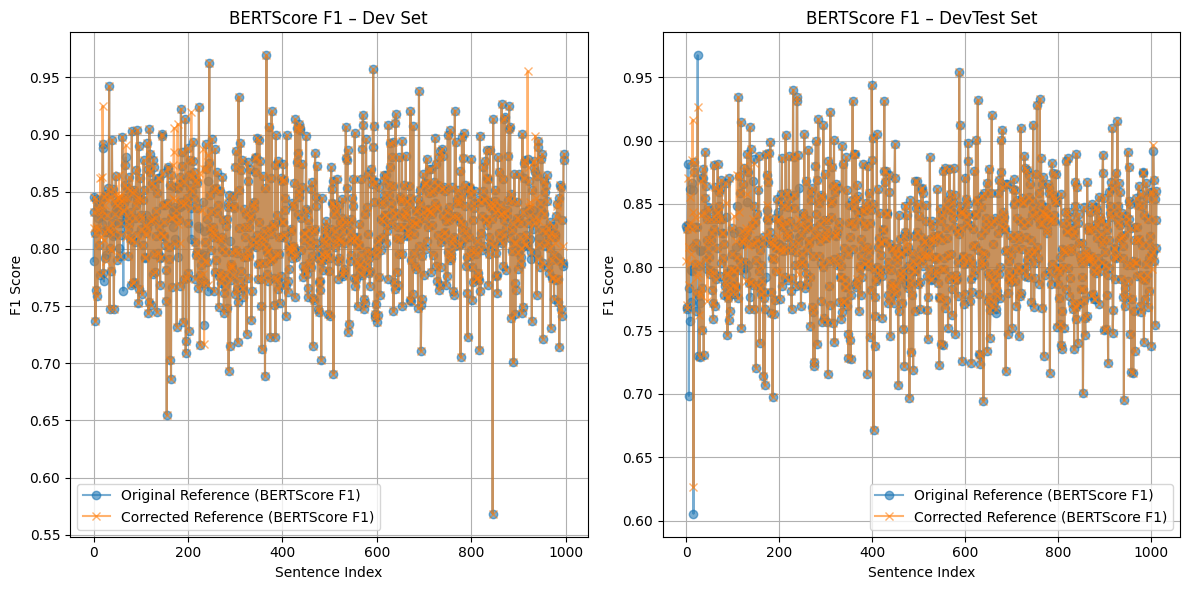


📊 Metric Comparison Summary (from previous cell):

--- Dev Set ---
📘 Evaluating: Dev


BLEU Original: 21.60 | Corrected: 36.92 | Multi: 26.69
chrF++ Original: 52.90 | Corrected: 62.70 | Multi: 55.80
BERTScore F1 Original: 0.8193 | Corrected: 0.8206


--- DevTest Set ---
📘 Evaluating: DevTest


BLEU Original: 19.11 | Corrected: 19.11 | Multi: 38.86
chrF++ Original: 53.04 | Corrected: 53.56 | Multi: 61.60
BERTScore F1 Original: 0.8173 | Corrected: 0.8179



In [21]:
# Use GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-use existing translations to calculate BERTScore F1 for plotting
print("Calculating BERTScore F1 for plotting...")
_, _, f1_orig_dev = bert_score(dev_translations, original_sepedi_references_dev, lang="nso", verbose=False, device=device)
_, _, f1_corr_dev = bert_score(dev_translations, all_corrected_references_by_lang["dev"]["nso_Latn"], lang="nso", verbose=False, device=device)

_, _, f1_orig_devtest = bert_score(devtest_translations, original_sepedi_references_devtest, lang="nso", verbose=False, device=device)
_, _, f1_corr_devtest = bert_score(devtest_translations, all_corrected_references_by_lang["devtest"]["nso_Latn"], lang="nso", verbose=False, device=device)
print("BERTScore F1 calculation complete.")

# Visualization for Dev set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(f1_orig_dev.cpu().numpy(), label="Original Reference (BERTScore F1)", marker='o', alpha=0.6)
plt.plot(f1_corr_dev.cpu().numpy(), label="Corrected Reference (BERTScore F1)", marker='x', alpha=0.6)
plt.title("BERTScore F1 – Dev Set")
plt.xlabel("Sentence Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

# Visualization for DevTest set
plt.subplot(1, 2, 2)
plt.plot(f1_orig_devtest.cpu().numpy(), label="Original Reference (BERTScore F1)", marker='o', alpha=0.6)
plt.plot(f1_corr_devtest.cpu().numpy(), label="Corrected Reference (BERTScore F1)", marker='x', alpha=0.6)
plt.title("BERTScore F1 – DevTest Set")
plt.xlabel("Sentence Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Metric Summary (re-printing from previous evaluation cell for clarity)
print("\n📊 Metric Comparison Summary (from previous cell):")
print("\n--- Dev Set ---")
evaluate_set("Dev", dev_translations, english_source_sentences_dev, original_sepedi_references_dev, all_corrected_references_by_lang["dev"]["nso_Latn"])
print("\n--- DevTest Set ---")
evaluate_set("DevTest", devtest_translations, english_source_sentences_devtest, original_sepedi_references_devtest, all_corrected_references_by_lang["devtest"]["nso_Latn"])